In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("laptop_price.csv", encoding="latin1", index_col="laptop_ID")
df.shape

(1303, 12)

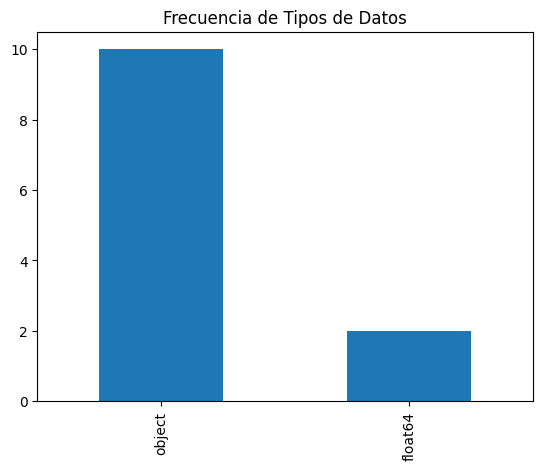

In [3]:
df.dtypes.value_counts().plot(kind="bar", title="Frecuencia de Tipos de Datos")
plt.show()

## Datos Categóricos

In [4]:
cat_variables = df.select_dtypes("object").columns.tolist()
df[cat_variables].head()

,Company,Product,TypeName,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
laptop_ID,,,,,,,,,,
1,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg
2,Apple,Macbook Air,Ultrabook,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg
3,HP,250 G6,Notebook,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg
4,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg
5,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg


In [5]:
def plot_cat(df, col, title=""):
    df[col].value_counts().plot(kind="bar", title=title)
    plt.show()

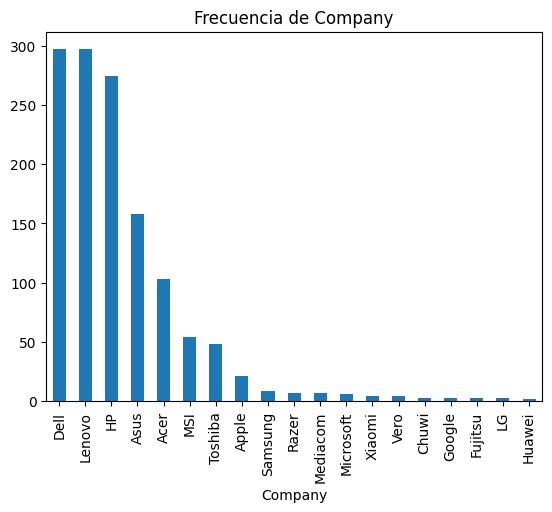

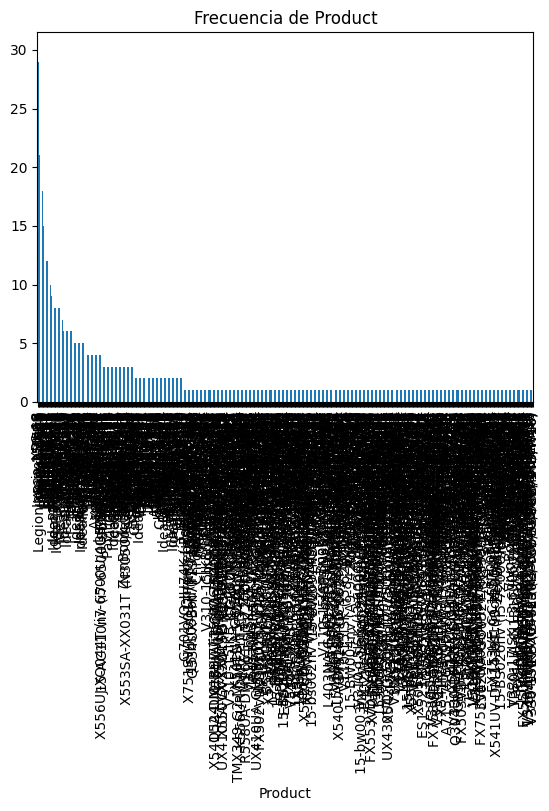

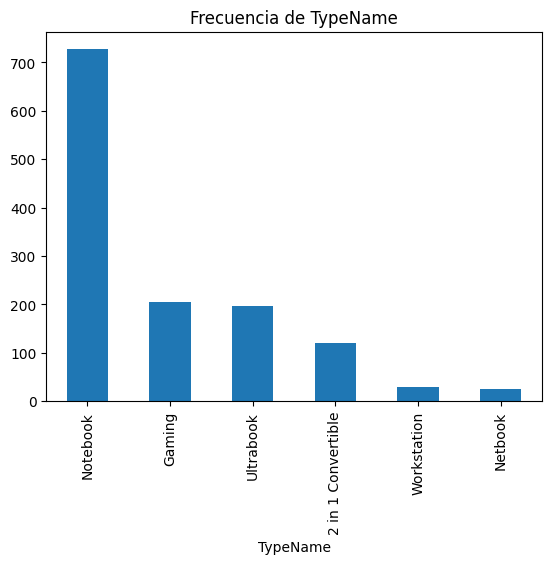

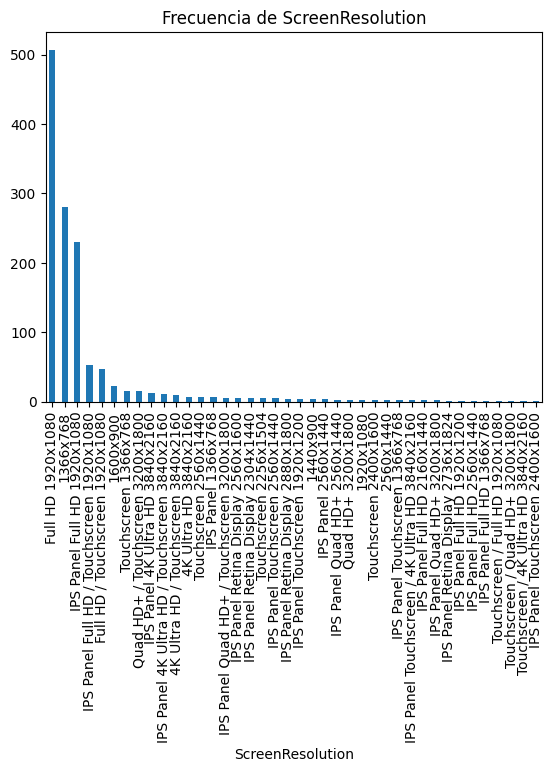

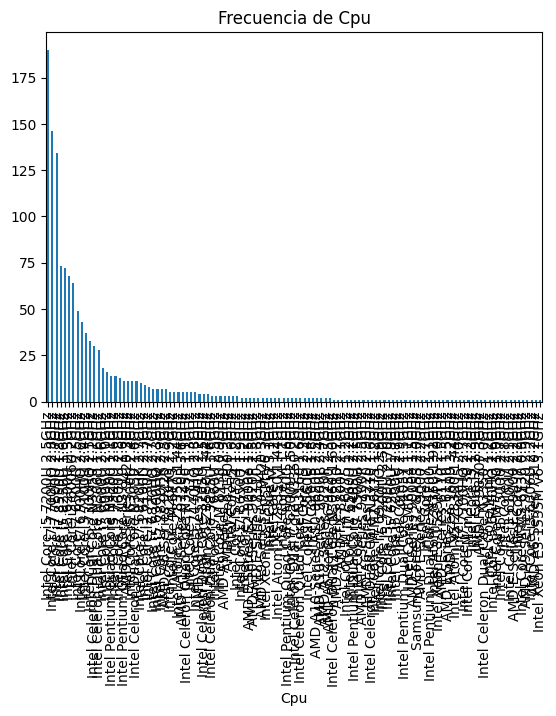

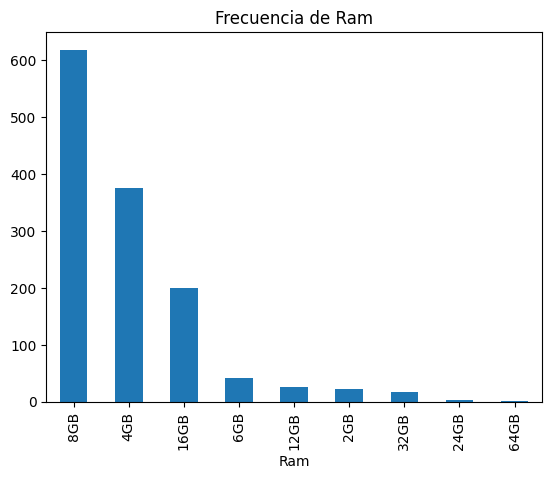

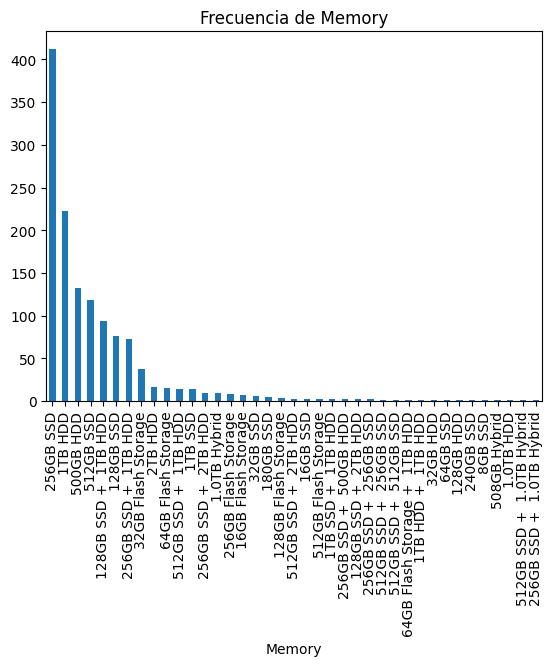

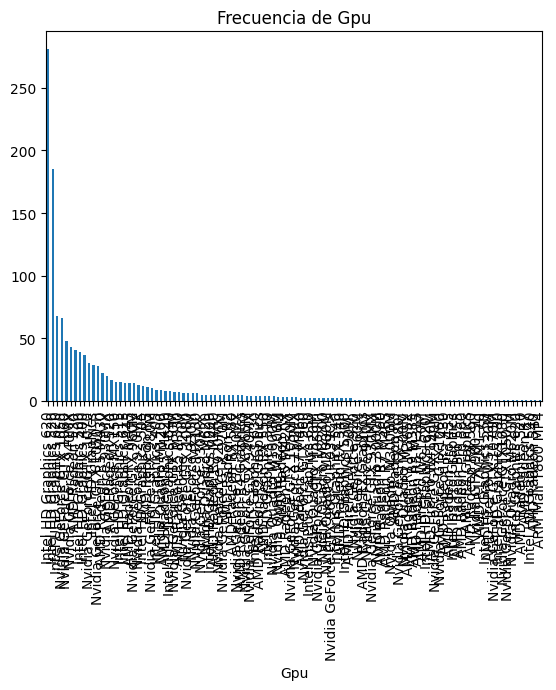

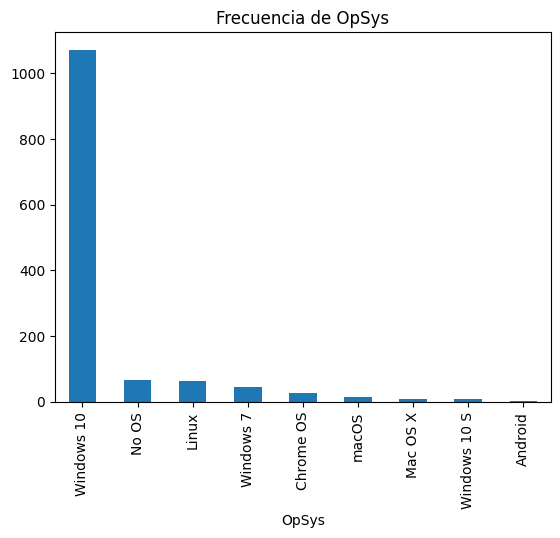

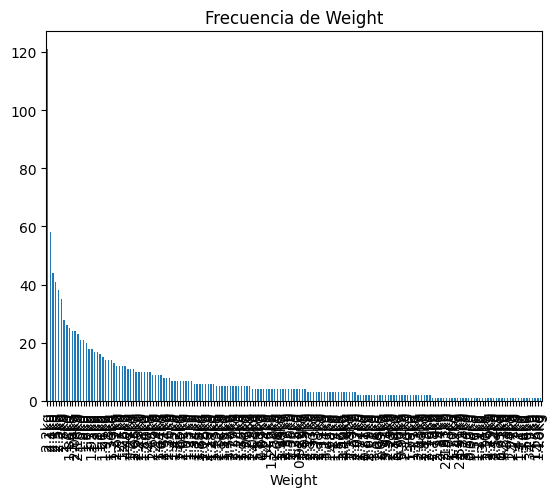

In [6]:
for col in cat_variables:
    plot_cat(df, col, f"Frecuencia de {col}")

> De acá se puede desprender que existen varias variables que quizás no vale la pena utilizar o quizás es mejor transformarlo.
- Company, TypeName y OpSys las utilizaremos tal cual están. 
- Probablemente RAM, Weight y Memory conviene transformalas en numéricas. 
- Del resto, quizás hay partes que vale la pena rescatar.

## Modelo Base

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

X = df.drop(columns="Price_euros")
y = df["Price_euros"]

RANDOM_STATE = 42
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)


def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = np.abs(y_true) + np.abs(y_pred)

    return 100 * np.nan_to_num(np.mean(num / den))


smape_metric = make_scorer(smape, greater_is_better=False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1042, 11), (1042,), (261, 11), (261,))

In [8]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

dm = DummyRegressor(strategy="mean")
dm.fit(X_train, y_train)
y_pred = dm.predict(X_test)
smape(y_test, y_pred)

23.50254453652047

In [9]:
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
lr = LinearRegression()
X_train_ohe = ohe.fit_transform(X_train)
# Problema acá, un Sistema indeterminado... Variables Multicolineales...
print(f"Shape Train: {X_train_ohe.shape}")
X_test_ohe = ohe.transform(X_test)
lr.fit(X_train_ohe, y_train)
y_pred_bs = lr.predict(X_test_ohe)
smape(y_test, y_pred_bs)

Shape Train: (1042, 1045)


20.915438008497492

## Feature Engineering

In [10]:
def extract_cpu_speed(df, col="Cpu"):
    data = df[col].str.extract(" (\d{0,1}.{0,1}\d+)GHz", expand=False)
    return data.str.replace("0 ", "", regex=True).astype(float)


def extract_memorysize(df, col="Memory"):
    data = df[col].str.extract("(\d+)GB|(\d+)TB", expand=False)
    return data[0].astype(float).fillna(0) + data[1].astype(float).mul(1024).fillna(0)


def extract_resolution(df, col="ScreenResolution"):
    data = df[col].str.extract("(\d+)x(\d+)", expand=False)
    return data.astype(int)


def extract_hd(df, col="Memory"):
    return (
        df[col]
        .str.extract("( SSD\s*| Flash Storage\s*| HDD\s*| Hybrid\s*)", expand=False)
        .str.strip()
    )


df["RAM(GB)"] = df["Ram"].replace("GB", "", regex=True).astype(int)
df["Weight(kg)"] = df["Weight"].replace("kg", "", regex=True).astype(float)
df["GPU_brand"] = df["Gpu"].str.split(" ", expand=True)[0]
df["cpu_speed(Ghz)"] = extract_cpu_speed(df)
df["Memory(GB)"] = extract_memorysize(df)
df[["W", "L"]] = extract_resolution(df)
df["hard_drive"] = extract_hd(df)
df["cpu_brand"] = df["Cpu"].str.split(" ", expand=True)[0]
df["cpu_i_model"] = df["Cpu"].str.extract("i(\d+)").astype(float)

In [11]:
df_final = df.drop(
    columns=[
        "ScreenResolution",
        "Cpu",
        "Ram",
        "Memory",
        "Gpu",
        "Weight",
        "Product",
    ]
)

# Valores Ausentes

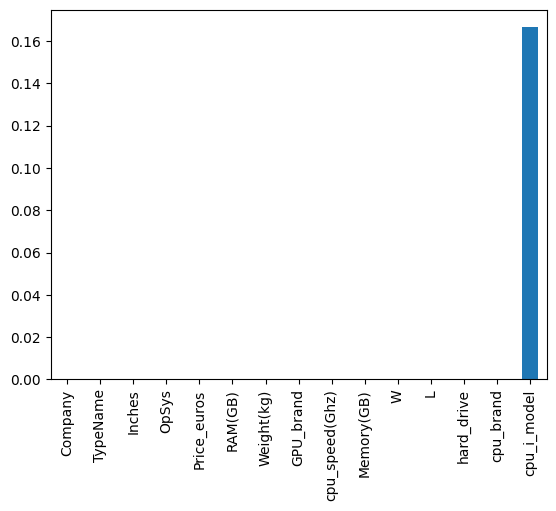

In [12]:
df_final.isnull().mean().plot(kind="bar")
plt.show()

> `cpu_i_model` tiene valores nulos, debido a que existen modelos que efectivamente no son tipo i. Por lo tanto estos valores ausentes son informativos. 

In [13]:
df_final.dtypes

Company            object
TypeName           object
Inches            float64
OpSys              object
Price_euros       float64
RAM(GB)             int64
Weight(kg)        float64
GPU_brand          object
cpu_speed(Ghz)    float64
Memory(GB)        float64
W                   int64
L                   int64
hard_drive         object
cpu_brand          object
cpu_i_model       float64
dtype: object

# Creación del Modelo

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

X = df_final.drop(columns="Price_euros")
y = df_final["Price_euros"]

RANDOM_STATE = 42
TEST_SIZE = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)


def smape(y_true, y_pred):
    num = np.abs(y_true - y_pred)
    den = np.abs(y_true) + np.abs(y_pred)

    return 100 * np.nan_to_num(np.mean(num / den))


smape_metric = make_scorer(smape, greater_is_better=False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1042, 14), (1042,), (261, 14), (261,))

In [15]:
from sklearn.pipeline import Pipeline
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn import set_config

set_config(transform_output="pandas")

OHE_VARIABLES = ["Company", "TypeName", "OpSys", "hard_drive", "cpu_brand", "GPU_brand"]
num_variables = [col for col in X_train.columns if col not in OHE_VARIABLES]


def define_model(model, num_variables=num_variables, ohe_variables=OHE_VARIABLES):
    scaler = SklearnTransformerWrapper(StandardScaler(), variables=num_variables)
    pipe = Pipeline(
        steps=[
            (
                "imp",
                ArbitraryNumberImputer(arbitrary_number=-1, variables=["cpu_i_model"]),
            ),
            ("ohe", OneHotEncoder(drop_last=True, variables=ohe_variables)),
            ("sc", scaler),
            ("model", model),
        ]
    )

    return pipe

In [16]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

N_ITER = 50000
lasso = Lasso(max_iter=N_ITER)
ridge = Ridge(max_iter=N_ITER)
lr = LinearRegression()

model_lasso = define_model(lasso)
model_ridge = define_model(ridge)
model_lr = define_model(lr)

model_lasso.fit(X_train, y_train)
model_ridge.fit(X_train, y_train)
model_lr.fit(X_train, y_train)

y_pred_lasso = model_lasso.predict(X_test)
y_pred_ridge = model_ridge.predict(X_test)
y_pred_lr = model_lr.predict(X_test)

In [17]:
print(f"SMAPE Lasso: {smape(y_test, y_pred_lasso)}")
print(f"SMAPE Ridge: {smape(y_test, y_pred_ridge)}")
print(f"SMAPE LR: {smape(y_test, y_pred_lr)}")

SMAPE Lasso: 12.78104660136152
SMAPE Ridge: 12.328899383294672
SMAPE LR: 12.101496299374443


In [18]:
from sklearn.model_selection import GridSearchCV, cross_val_score


def run_cv(lr, lasso, ridge, X_train, y_train, metric=smape_metric):
    lr_result = -cross_val_score(lr, X_train, y_train, scoring=metric, cv=5).mean()
    params = {"model__alpha": np.logspace(-3, 3, 7)}
    search_lasso = GridSearchCV(lasso, params, scoring=smape_metric, cv=5)
    search_ridge = GridSearchCV(ridge, params, scoring=smape_metric, cv=5)

    search_lasso.fit(X_train, y_train)
    search_ridge.fit(X_train, y_train)
    return lr_result, search_lasso, search_ridge


lr_result, search_lasso, search_ridge = run_cv(
    model_lr, model_lasso, model_ridge, X_train, y_train
)

In [19]:
results_lasso = pd.DataFrame(search_lasso.cv_results_).sort_values("rank_test_score")
results_ridge = pd.DataFrame(search_ridge.cv_results_).sort_values("rank_test_score")

In [20]:
results_lasso.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.065398,0.032902,0.024068,0.000484,0.1,{'model__alpha': 0.1},-11.407781,-10.952558,-14.176014,-10.844303,-12.660209,-12.008173,1.261275,1
1,0.148681,0.035395,0.024264,0.000576,0.01,{'model__alpha': 0.01},-11.483807,-11.017046,-14.257246,-10.840014,-12.722026,-12.064028,1.278609,2
0,0.567524,0.181861,0.024933,0.001992,0.001,{'model__alpha': 0.001},-11.487832,-11.050284,-14.290080,-10.828337,-12.734922,-12.078291,1.287711,3
4,0.036925,0.001590,0.023965,0.000585,10.0,{'model__alpha': 10.0},-11.728041,-11.669964,-12.338614,-11.792636,-13.088337,-12.123519,0.538282,4
3,0.038895,0.001985,0.024335,0.000767,1.0,{'model__alpha': 1.0},-11.709788,-11.189078,-13.881934,-11.375356,-12.747330,-12.180697,1.006868,5


In [21]:
results_ridge.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,0.034124,0.000631,0.023275,0.000524,0.1,{'model__alpha': 0.1},-11.453347,-10.961935,-14.220871,-10.841671,-12.695706,-12.034706,1.275020,1
1,0.034170,0.000608,0.023369,0.000599,0.01,{'model__alpha': 0.01},-11.488432,-11.035959,-14.278975,-10.829731,-12.729789,-12.072577,1.285347,2
0,0.035584,0.005756,0.028187,0.009684,0.001,{'model__alpha': 0.001},-11.488568,-11.052546,-14.289940,-10.827168,-12.735608,-12.078766,1.287532,3
3,0.034105,0.000561,0.023274,0.000545,1.0,{'model__alpha': 1.0},-11.450514,-11.053958,-14.204728,-11.004341,-12.688521,-12.080412,1.223996,4
5,0.034031,0.000536,0.023249,0.000459,100.0,{'model__alpha': 100.0},-11.988375,-11.741900,-12.880104,-11.511850,-12.974523,-12.219350,0.598121,5


In [22]:
def model_eval(lr, lasso, ridge, X_test, y_test):
    lr_test = lr.predict(X_test)
    lasso_test = lasso.predict(X_test)
    ridge_test = ridge.predict(X_test)

    print(f"SMAPE LR: {smape(y_test, lr_test)}")
    print(f"SMAPE Lasso: {smape(y_test, lasso_test)}")
    print(f"SMAPE Ridge: {smape(y_test, ridge_test)}")


model_eval(model_lr, model_lasso, model_ridge, X_test, y_test)

SMAPE LR: 12.101496299374443
SMAPE Lasso: 12.78104660136152
SMAPE Ridge: 12.328899383294672


In [23]:
prep_features = model_lasso.named_steps["ohe"].get_feature_names_out()
print(f"Número de Features Totales: {len(prep_features)}")


idx = model_lasso.named_steps["model"].coef_ == 0
np.array(prep_features)[idx]

Número de Features Totales: 47


array(['W', 'Company_Google', 'Company_MSI', 'Company_Vero',
       'Company_Mediacom', 'Company_Samsung', 'Company_Microsoft',
       'Company_Chuwi', 'Company_Xiaomi', 'Company_Huawei',
       'OpSys_Windows 10', 'OpSys_Chrome OS', 'OpSys_Mac OS X',
       'OpSys_Windows 10 S', 'OpSys_macOS', 'hard_drive_HDD',
       'hard_drive_Flash Storage', 'cpu_brand_AMD', 'GPU_brand_Nvidia'],
      dtype='<U27')

In [24]:
from feature_engine.selection import DropFeatures

drop_features = ["W", "Company", "OpSys", "hard_drive", "cpu_brand", "GPU_brand"]
ohe_variables_v2 = [col for col in OHE_VARIABLES if col not in drop_features]
num_variables_v2 = [col for col in num_variables if col not in drop_features]


def define_model_v2(
    model,
    num_variables=num_variables,
    ohe_variables=OHE_VARIABLES,
    drop_features=drop_features,
):
    scaler = SklearnTransformerWrapper(StandardScaler(), variables=num_variables)
    pipe = Pipeline(
        steps=[
            ("drop", DropFeatures(features_to_drop=drop_features)),
            (
                "imp",
                ArbitraryNumberImputer(arbitrary_number=-1, variables=["cpu_i_model"]),
            ),
            ("ohe", OneHotEncoder(drop_last=True, variables=ohe_variables)),
            ("sc", scaler),
            ("model", model),
        ]
    )

    return pipe


lasso_v2 = define_model_v2(
    lasso, ohe_variables=ohe_variables_v2, num_variables=num_variables_v2
)
ridge_v2 = define_model_v2(
    ridge, ohe_variables=ohe_variables_v2, num_variables=num_variables_v2
)
lr_v2 = define_model_v2(
    lr, ohe_variables=ohe_variables_v2, num_variables=num_variables_v2
)

lasso_v2.fit(X_train, y_train)
ridge_v2.fit(X_train, y_train)
lr_v2.fit(X_train, y_train)

Pipeline(steps=[('drop',
                 DropFeatures(features_to_drop=['W', 'Company', 'OpSys',
                                                'hard_drive', 'cpu_brand',
                                                'GPU_brand'])),
                ('imp',
                 ArbitraryNumberImputer(arbitrary_number=-1,
                                        variables=['cpu_i_model'])),
                ('ohe', OneHotEncoder(drop_last=True, variables=['TypeName'])),
                ('sc',
                 SklearnTransformerWrapper(transformer=StandardScaler(),
                                           variables=['Inches', 'RAM(GB)',
                                                      'Weight(kg)',
                                                      'cpu_speed(Ghz)',
                                                      'Memory(GB)', 'L',
                                                      'cpu_i_model'])),
                ('model', LinearRegression())])

In [25]:
lr_result_v2, search_lasso_v2, search_ridge_v2 = run_cv(
    lr_v2, lasso_v2, ridge_v2, X_train, y_train
)

In [26]:
lr_result_v2

12.367774399661588

In [27]:
results_lasso_v2 = pd.DataFrame(search_lasso_v2.cv_results_).sort_values(
    "rank_test_score"
)
results_ridge_v2 = pd.DataFrame(search_ridge_v2.cv_results_).sort_values(
    "rank_test_score"
)
results_lasso_v2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.019954,0.001648,0.011726,0.000147,0.001,{'model__alpha': 0.001},-11.882241,-11.681397,-12.721093,-11.468807,-14.085916,-12.367891,0.958315,1
1,0.020784,0.000258,0.011827,0.000041,0.01,{'model__alpha': 0.01},-11.882128,-11.683010,-12.722926,-11.470202,-14.086415,-12.368936,0.958148,2
2,0.020718,0.000174,0.011998,0.000046,0.1,{'model__alpha': 0.1},-11.881722,-11.699537,-12.741187,-11.484140,-14.091368,-12.379591,0.956359,3
3,0.020544,0.000108,0.012024,0.000076,1.0,{'model__alpha': 1.0},-11.903820,-11.959502,-12.919613,-11.657156,-14.158820,-12.519782,0.925609,4
4,0.020224,0.000140,0.011983,0.000022,10.0,{'model__alpha': 10.0},-12.225569,-12.181133,-12.841826,-11.627879,-14.022430,-12.579768,0.817363,5


In [28]:
results_ridge_v2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.018386,0.002522,0.011147,0.001529,0.001,{'model__alpha': 0.001},-11.882262,-11.681402,-12.721134,-11.468816,-14.085960,-12.367915,0.958330,1
1,0.014864,0.000235,0.008930,0.000092,0.01,{'model__alpha': 0.01},-11.882337,-11.683051,-12.723335,-11.470288,-14.086855,-12.369173,0.958293,2
2,0.014920,0.000716,0.008728,0.000211,0.1,{'model__alpha': 0.1},-11.883172,-11.699028,-12.744585,-11.484526,-14.095522,-12.381367,0.957952,3
3,0.014991,0.000538,0.008874,0.000227,1.0,{'model__alpha': 1.0},-11.899343,-11.853369,-12.899958,-11.601341,-14.167326,-12.484267,0.951337,4
5,0.014373,0.000226,0.008614,0.000066,100.0,{'model__alpha': 100.0},-12.313292,-12.338274,-12.976062,-11.826257,-14.078669,-12.706511,0.777244,5


In [29]:
model_eval(lr_v2, lasso_v2, ridge_v2, X_test, y_test)

SMAPE LR: 12.26249617772726
SMAPE Lasso: 12.580261154131028
SMAPE Ridge: 12.43812155139204
